In [ ]:
import sys
sys.path.append('../')
from config import cfg
from models import get_pose_net
from data_load import load_data
import torch
import matplotlib.pyplot as plt
import tqdm
import copy
import numpy as np
from scipy.ndimage import maximum_filter

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_model = None
        self.best_loss = None
        self.counter = 0
        self.status = ""

    def __call__(self, model, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())
        elif self.best_loss - val_loss >= self.min_delta:
            self.best_model = copy.deepcopy(model.state_dict())
            self.best_loss = val_loss
            self.counter = 0
            self.status = f"Improvement found, counter reset to {self.counter}"
        else:
            self.counter += 1
            self.status = f"No improvement in the last {self.counter} epochs"
            if self.counter >= self.patience:
                self.status = f"Early stopping triggered after {self.counter} epochs."
                if self.restore_best_weights:
                    model.load_state_dict(self.best_model)
                return True
        return False

def weighted_mse_loss(output, target, visibility_value):
    # Calculate the squared error between predicted and target landmarks
    squared_error = visibility_value.unsqueeze(2).unsqueeze(3).unsqueeze(4) * (output - target) ** 2
    
    # Compute the mean loss while considering visibility
    loss = squared_error.mean()
    
    return loss

def train(model, epoch, es, device, train_loader, optimizer, criterion):
    done = False
    
    model.train()
    running_loss = 0.0
    print(f"Epoch: {epoch}")
    for batch_index, (input, target, visibility) in enumerate(train_loader):
        input = input.to(device)
        target = target.to(device)
        visibility = visibility.to(device)

        output = model(input)
        loss = criterion(output.unsqueeze(2), target, visibility)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss = loss.item()
        running_loss += loss

        if (batch_index+1) % 10 == 0:
            print(f"Batch: {batch_index+1}/{len(train_loader)}, loss: {loss}")
        
        if (batch_index+1) % 100 == 0:
            torch.save(model.state_dict(), f'versions/hrnet_{epoch}_{batch_index+1}.pt')
    torch.save(model.state_dict(), f'versions/hrnet_{epoch}_{batch_index+1}.pt')

    return done

def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    
    with torch.no_grad():
        for batch_index, (input, target, visibility) in enumerate(test_loader):
            input = input.to(device)
            target = target.to(device)
            visibility = visibility.to(device)
            output = model(input)
            test_loss += criterion(output.unsqueeze(2), target, visibility).item()
            
    test_loss /= len(test_loader)
    print(f'\nTest set: Average loss: {test_loss}\n')

def main(pre_trained=False, pre_trained_path=None):
    device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
    print(f'Using device {device}')
    
    train_loader, test_loader = load_data(cfg.DATASET.ROOT, batch_size=4) #cfg.TRAIN.BATCH_SIZE_PER_GPU
    print("Data loaded")

    model = get_pose_net(cfg, False)

    if pre_trained:
        model.load_state_dict(torch.load(pre_trained_path))
        print("Pre-trained model loaded")

    model = model.to(device)

    es = EarlyStopping(patience=3)
    criterion = weighted_mse_loss
    optimizer = torch.optim.Adam(model.parameters(), lr=cfg.TRAIN.LR)
    
    print("\nTRAINING PHASE")
    epoch = 0
    es_done = False
    while epoch < cfg.TRAIN.END_EPOCH and not es_done:
        epoch += 1
        es_done = train(model, epoch, es, device, train_loader, optimizer, criterion)
    
    print("\nTESTING PHASE")
    test(model, device, test_loader, criterion)


In [ ]:
if __name__ == '__main__':
    main(pre_trained = False, pre_trained_path = 'versions/hrnet1_7_3200.pt')

In [ ]:
pre_trained = True

In [ ]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f'Using device {device}')

model = get_pose_net(cfg, False)
if pre_trained:
    model.load_state_dict(torch.load('versions/hrnet1_7_3200.pt', map_location='cpu'))
    print("Pre-trained model loaded")

model = model.to(device)

In [35]:
train_loader, test_loader = load_data(cfg.DATASET.ROOT, batch_size=4) #cfg.TRAIN.BATCH_SIZE_PER_GPU
print("Data loaded")

Data loaded


INPUT:


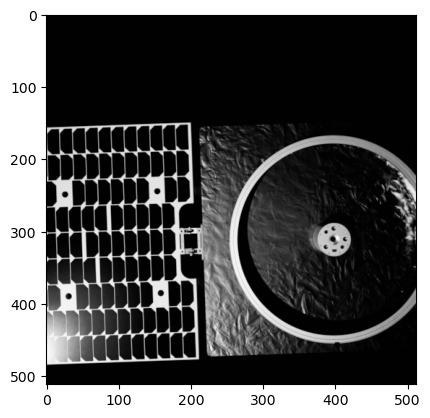

TARGET:
[[(397, 310), 1], [(153, 244), 1], [(199, 259), 1], [(178, 263), 1], [(187, 299), 1], [(188, 327), 1], [(182, 364), 1], [(203, 366), 1], [(158, 384), 1]]
OUTPUT:
[[(396, 309), 1], [(152, 243), 1], [(198, 256), 1], [(177, 262), 1], [(186, 298), 1], [(187, 326), 1], [(181, 363), 1], [(202, 365), 1], [(157, 383), 1]]
Batch 0 --> loss: 3.3048057957785204e-05
--------------------------------------------------

Test set: Average loss: 4.1310072447231504e-08



In [37]:
def get_position(img, saved_landmarks=None, threshold=-0.5):
    lndx = None
    lndy = None
    visibility = 0
    if np.max(img) > threshold:
        lndy, lndx = np.where(img == np.max(img))
        lndy, lndx = lndy[0], lndx[0]
        if saved_landmarks is not None or len(saved_landmarks) > 0:
            for lnd, vis in saved_landmarks:
                if vis == 1 and abs(lndx - lnd[0]) <= 3 and abs(lndy - lnd[1]) <= 3:
                    lndx = None
                    lndy = None
                    return (lndx, lndy), visibility
        visibility = 1
    
    return (lndx, lndy), visibility

def get_landmarks(landmarks_images):
    landmarks2D = []
    for img in landmarks_images:
        lnd_pos, vis = get_position(img, landmarks2D)
        landmarks2D.append([lnd_pos, vis])

    return landmarks2D


model.eval()
test_loss = 0.0
with torch.no_grad():
    for batch_index, (input, target, visibility) in enumerate(test_loader):
        input = input.to(device)
        target = target.to(device)
        visibility = visibility.to(device)
        output = model(input)
        inp = input[0].squeeze(0)
        print('INPUT:')
        plt.imshow(inp.cpu().detach().numpy(), cmap='gray')
        plt.show()
        tar = target[0].squeeze(1).detach().numpy()
        out = output[0].detach().numpy()
        target_landmarks = get_landmarks(tar)
        out_landmarks = get_landmarks(out)
        print('TARGET:')
        print(target_landmarks)
        print('OUTPUT:')
        print(out_landmarks)
        test_loss += weighted_mse_loss(output.unsqueeze(2), target, visibility).item()
        print(f'Batch {batch_index} --> loss: {test_loss}')
        print('--------------------------------------------------')
        break

test_loss /= len(test_loader)
print(f'\nTest set: Average loss: {test_loss}\n')

LANDMARKS ANALYSIS

In [ ]:
def threshold(out_images):
    for i in range(out_images.shape[0]):
        threshold_low = 0.5
        #threshold_high = np.mean(out_images[i]) + 20 * np.std(out_images[i])
        mask1 = out_images[i] < threshold_low
        #mask2 = out_images[i] > threshold_high
        out_images[i][mask1] = 0
        #out_images[i][mask2] = 1
    return out_images

def shadowing(out_images, dark_areas):
    for area in dark_areas:
        out_images[area[1]-2:area[1]+3, area[0]-2:area[0]+3] = np.min(out_images)
    return out_images

def search_center(img, window_size=5):
    # Initialize the maximum average brightness and the center of the brightest window
    max_brightness = 0
    brightest_center = (0, 0)

    # Iterate over all possible windows in the image
    for i in range(img.shape[0] - window_size + 1):
        for j in range(img.shape[1] - window_size + 1):
            # Compute the average brightness of the current window
            window = img[i:i+window_size, j:j+window_size]
            avg_brightness = np.mean(window)

            # Update the maximum average brightness and the center of the brightest window
            if avg_brightness > max_brightness:
                max_brightness = avg_brightness
                brightest_center = (j+window_size//2, i+window_size//2)

    return brightest_center, max_brightness

def search_bright_areas(img, n):
    # Initialize a list of bright areas
    bright_areas = []
    found = False
    # Iterate over all possible nxn windows in the image
    for i in range(img.shape[0] - n + 1):
        for j in range(img.shape[1] - n + 1):
            # Compute the average brightness of the current window
            window = img[i:i+n, j:j+n]
            avg_brightness = np.mean(window)
            # Add the current window to the list of bright areas if its average brightness is greater than 0.6
            if avg_brightness > 0.2:
                found = False
                if len(bright_areas) == 0:
                    bright_areas.append((j, i))
                else:
                    for area in bright_areas:
                        if abs(j - area[0]) < 7 and abs(i - area[1]) < 7:
                            area = (round((j + area[0])/2), round((i + area[1])/2))
                            found = True
                    if not found:
                        bright_areas.append((j, i))
 
    return bright_areas

def circular_search(arr):
    
    rows, cols = arr.shape

    start_row, start_col = rows // 2, cols // 2

    # Define the clockwise traversal pattern (right, down, left, up)
    directions = [(0, 1), (1, 0), (0, -1), (-1, 0)]

    # Initialize an empty list to store the searched elements
    searched_elements = []

    # Perform the clockwise search
    current_row, current_col = start_row, start_col
    for dr, dc in directions:
        while 0 <= current_row < rows and 0 <= current_col < cols:
            searched_elements.append(arr[current_row, current_col])
            current_row += dr
            current_col += dc

    # Print the searched elements in clockwise order
    print(searched_elements)

In [ ]:
input, target, visibility = test_loader.dataset[547]
output = model(input.unsqueeze(0))
output = output.squeeze(0).detach().numpy()
target = target.squeeze(1).numpy()
visibility = visibility.squeeze(0).numpy()
output = output[visibility == 1]
target = target[visibility == 1]

plt.imshow(input.squeeze(0).numpy(), cmap='gray')
plt.show()


In [ ]:
n = 7
output_th = output.copy()

output_th[n] = (output_th[n] - np.min(output_th[n])) / (np.max(output_th[n]) - np.min(output_th[n]))
output_th[n] = threshold(output_th[n])
target[n] = (target[n] - np.min(target[n])) / (np.max(target[n]) - np.min(target[n]))
#plt.imshow(output_th[n], cmap='gray')
#plt.show()
#plt.imshow(target[n], cmap='gray')
#plt.show()
dark_areas = []
max_img = maximum_filter(output_th[4], size=3, mode='constant')
center_y, center_x = np.unravel_index(np.argmax(max_img, axis=None), output_th[4].shape)
dark_areas.append((center_x, center_y))
max_img = maximum_filter(output_th[7], size=3, mode='constant')



center_y, center_x = np.unravel_index(np.argmax(max_img, axis=None), output_th[4].shape)
dark_areas.append((center_x, center_y))
summed_out = np.zeros((512,512))
for i in range(0,output_th.shape[0]):
    if i != 4 and i != 7 and i != 3 and i!= 8:
        summed_out += output_th[i]
        print(i)
        output_th[i] = (output_th[i] - np.min(output_th[i])) / (np.max(output_th[i]) - np.min(output_th[i]))
        output_th[i] = threshold(output_th[i])
        output_th[i] = shadowing(output_th[i], dark_areas)
        plt.imshow(output_th[i], cmap='gray')
        plt.show()
        out = output_th[i]
        
        max_img = maximum_filter(output_th[i], size=3, mode='constant')
        print(np.max(max_img))
        center_y, center_x = np.unravel_index(np.argmax(max_img, axis=None), output_th[4].shape)
        print("Predected center:",center_x, center_y)
        max_img_t = maximum_filter(target[i], size=3, mode='constant')
        center_y, center_x = np.unravel_index(np.argmax(max_img_t, axis=None), target[4].shape)
        print("Target center:", center_x, center_y, '\n')
        bright__areas = search_bright_areas(output_th[i], 3)
        print("Bright areas:", bright__areas)


summed_out = (summed_out - np.min(summed_out)) / (np.max(summed_out) - np.min(summed_out))
summed_out = threshold(summed_out)
plt.imshow(summed_out, cmap='gray')
plt.show()


In [ ]:


def dark_loop(dark_areas, landmark):
    is_new_center = False
    for area in dark_areas:
        landmark['out_image'][area[1]-2:area[1]+3, area[0]-2:area[0]+3] = -1
    center, bright = search_center(landmark['out_image'])
    # Check if the center has changed with 2 pixels of tolerance

    if abs(center[0] - landmark['center_position'][0]) > 2 or abs(center[1] - landmark['center_position'][1]) > 2:
        landmark['center_position'], landmark['highest_avg_brightness'] = center, bright
        is_new_center = True
        print(f"New center found: {center}")
    return is_new_center, landmark

def analyze_landmarks(test_loader, model):
    input, target, visibility = test_loader.dataset[0]
    output = model(input.unsqueeze(0))
    output = output.squeeze(0).detach().numpy()
    target = target.squeeze(1).numpy()
    visibility = visibility.squeeze(0).numpy()
    output = output[visibility == 1]
    target = target[visibility == 1]

    landmarks = []
    for i in range(len(output)):
        output[i] = threshold(output[i])
        
        t_center, t_highest_average_brightness = search_center(target[i], window_size=3)
        center_position, highest_average_brightness = search_center(output[i], window_size=3)
        
        bright_dict = {
                'target_img': target[i], 
                'out_image': output[i],
                'target_center': t_center,
                'center_position': center_position, 
                'highest_avg_brightness': highest_average_brightness,
                'avg_brightness_err': (np.mean(output[i])+1)**2
                }
        landmarks.append(bright_dict)

    return landmarks

In [ ]:
model = get_pose_net(cfg, False)
model.load_state_dict(torch.load('versions/hrnet_9_1800.pt', map_location='cpu'))

In [ ]:
landmarks = analyze_landmarks(test_loader, model)

In [ ]:
landmarks.sort(key=lambda x: x['highest_avg_brightness'], reverse=False)
for i, lnd in enumerate(landmarks):
    print(f"Landmark {i}")
    plt.imshow(lnd['target_img'], cmap='gray')
    plt.show()
    plt.imshow(lnd['out_image'], cmap='gray')
    plt.show()
    print(lnd['center_position'], lnd['target_center'], lnd['highest_avg_brightness'], lnd['avg_brightness_err'])

In [ ]:
last_checked = 0
dark_areas = []
while last_checked < len(landmarks):
    landmarks.sort(key=lambda x: x['highest_avg_brightness'], reverse=True)
    for i in range(last_checked, len(landmarks)):
        last_checked = i
        print(f"Last checked: {last_checked}, Current: {i}")
        is_new_center, landmarks[i] = dark_loop(dark_areas, landmarks[i])
        if is_new_center:
            break
        else:
            target_img = landmarks[i]['target_img']
            out_img = landmarks[i]['out_image']
            plt.imshow(target_img, cmap='gray')
            plt.show()
            plt.imshow(out_img, cmap='gray')
            plt.show()
            print(f"Center: {landmarks[i]['center_position']}")
            dark_areas.append(landmarks[i]['center_position'])